In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Lion
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sklearn as sk
from sklearn.model_selection import train_test_split
import pickle

print(tf.__version__)

2024-11-29 22:18:41.473905: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-29 22:18:41.482085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 22:18:41.490851: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 22:18:41.493525: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 22:18:41.500561: I tensorflow/core/platform/cpu_feature_guar

2.17.0


In [2]:
tf.config.list_physical_devices('GPU')

I0000 00:00:1732943924.484340  502449 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732943924.510590  502449 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732943924.512988  502449 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
inputs = np.load("all_inputs_aug.npy")
targets = np.load("all_targets_aug.npy")
# train test split
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2)

In [5]:
conv_dim = 16
ff_dim = 32
k_dim1 = 5
k_dim2 = 21
pool_dim1 = 5
pool_dim2 = 3
drop_rate = 0.2

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim1, k_dim1), activation='relu', input_shape=(512, 512, 1)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPooling2D(pool_dim1,pool_dim1),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim2, k_dim2), padding ='valid'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPooling2D(pool_dim2,pool_dim2),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim2, k_dim2), padding ='valid'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPooling2D(pool_dim2,pool_dim2),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(ff_dim, activation='relu'),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

/home/user/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 508, 508, 16)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 508, 508, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 508, 508, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 101, 101, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 101, 101, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 81, 81, 16)     │       112,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 81, 81, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 81, 81, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 27, 27, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 27, 27, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 16)       │       112,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,545 (892.75 KB)

 Trainable params: 228,449 (892.38 KB)

 Non-trainable params: 96 (384.00 B)

In [6]:
model.compile(optimizer=Adam(learning_rate=1e-3,weight_decay = 0.01), # use 1e-4 (10 times smaller than what was used with Adam)
              loss='binary_crossentropy',  
              metrics=['accuracy'])

In [9]:
# add callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [10]:
optim = model.fit(X_train,y_train, 
                  batch_size = 32,
                  epochs=100, 
                  validation_split =.2,
                  callbacks=[callback])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8992 - loss: 0.2358 - val_accuracy: 0.6719 - val_loss: 0.6350
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9300 - loss: 0.1703 - val_accuracy: 0.5371 - val_loss: 2.0484
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9460 - loss: 0.1257 - val_accuracy: 0.4858 - val_loss: 4.4623
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9520 - loss: 0.1234 - val_accuracy: 0.4968 - val_loss: 4.3788


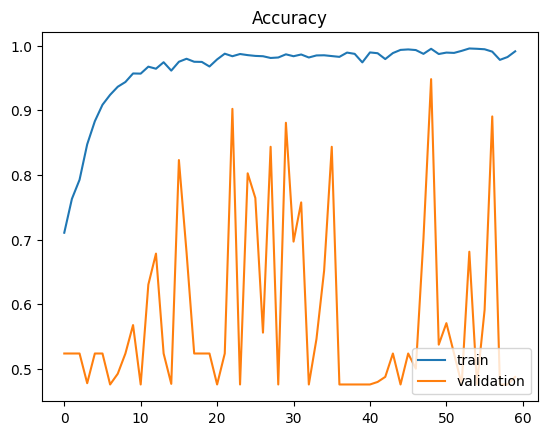

In [7]:
plt.plot(optim.history['accuracy'])
plt.plot(optim.history['val_accuracy'])
plt.legend(['train', 'validation'], loc='lower right')
plt.title('Accuracy')
plt.show()

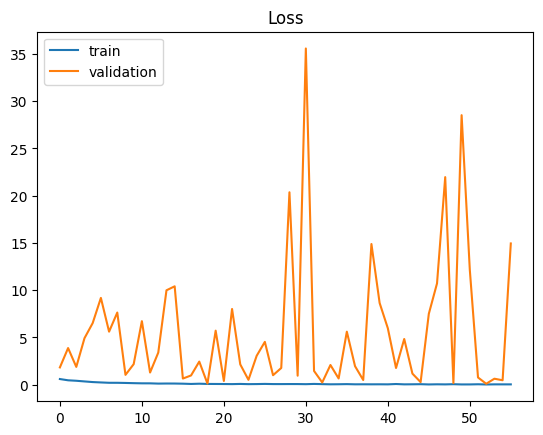

In [17]:
plt.plot(optim.history['loss'])
plt.plot(optim.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title('Loss')
plt.show()